# Web Scraping with `requests` and `beautifulsoup4`

Web scraping ist the term for using a program to download and process content from the Web. We will use the Python libraries `requests` and `beautifulsoup4` for web scraping extreme temperature data. 

## Installation and Documentation 

### `requests`

 - Documentation: [https://docs.python-requests.org/en/latest/ ](https://docs.python-requests.org/en/latest/)
 - Installation: 
     - Anaconda: usually already part of the Anaconda installation; if not, then use `conda install requests`
     - pip: `pip install requests`

### Beautiful Soup

 - Documentation: [https://beautiful-soup-4.readthedocs.io/en/latest/](https://beautiful-soup-4.readthedocs.io/en/latest/)
 - Installation:
     - Anaconda: `conda install beautifulsoup4 lxml`
     - pip: `pip install beautifulsoup4`; you also need an HTML parser: `pip install lxml`

## Example: Creating BeautifulSoup Objects from local HTML files 

In [1]:
import bs4

In [2]:
example = open("./html/example.html")
soup = bs4.BeautifulSoup(example.read())

### Finding an Element with `select()`

You can pass a __selector__ to the `select()` method and retrieve a specific web page element this way. 

_Your job_: If you are interested in more details on selectors read one of the following excellent tutorials:
 - [https://ryanstutorials.net/css-tutorial/css-selectors.php](https://ryanstutorials.net/css-tutorial/css-selectors.php)
 - [https://htmldog.com/guides/css/beginner/selectors/](https://htmldog.com/guides/css/beginner/selectors/)
 - [https://www.w3.org/TR/CSS2/selector.html](https://www.w3.org/TR/CSS2/selector.html)

Important for us:

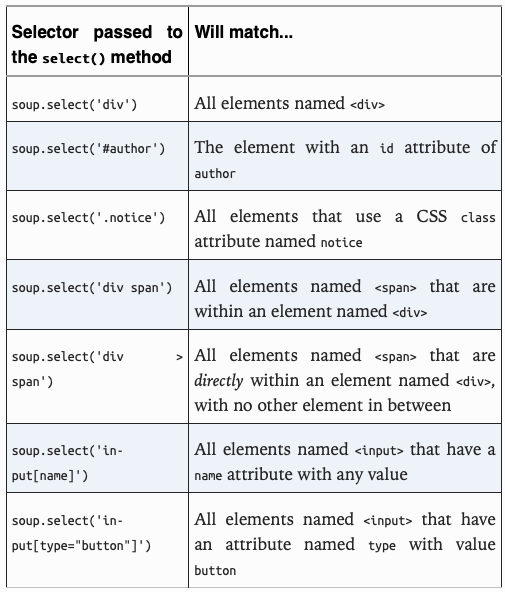

<font size='2px'>Image Source: Al Sweigart. “Automate the Boring Stuff with Python: Practical Programming for Total Beginners.”</font>

In [3]:
authors = soup.select("#author")
authors

[<span id="author">Mister Data</span>]

In [4]:
len(authors)

1

In [5]:
authors[0].getText()

'Mister Data'

In [6]:
authors[0].attrs

{'id': 'author'}

In [7]:
p_elems = soup.select('p')
p_elems

[<p>Download this file <strong>example.html</strong> from the Moodle <a href="https://moodle.haw-landshut.de/">course website</a>.</p>,
 <p class="slogan">Learn Data Visualization the easy way!</p>,
 <p>By <span id="author">Mister Data</span></p>]

In [8]:
p_elems[2].getText()

'By Mister Data'

In [9]:
span_elems = soup.select("span")
span_elems

[<span id="author">Mister Data</span>]

In [10]:
span_elems[0].get("id")

'author'

## Web Scraping [Extreme Temperature Data from Wikipedia](https://en.wikipedia.org/wiki/List_of_extreme_temperatures_in_Germany)

Now, let's try to scrape some extreme temperature related data from the corresponding Wikipedia site.

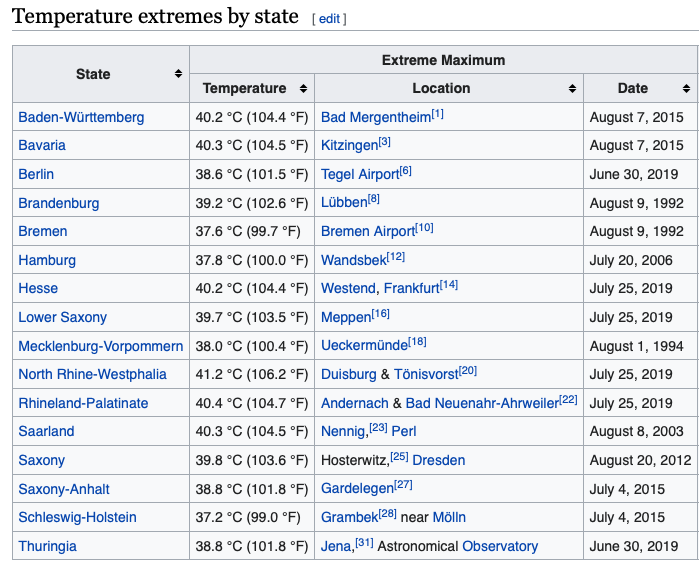



## Retrieving Web Data with Python 

A fundamental part of the data visualizer's skill set is the retrieval of data from the Web. Python provides us with excellent libraries for that type of job.

 - getting web content in order to parse it for data involves making HTTP requests 
 - getting web content with the `requests` library: 

In [11]:
import requests

In [12]:
response = requests.get("https://en.wikipedia.org/wiki/List_of_extreme_temperatures_in_Germany")

In [13]:
response.status_code

200

For an overview on status codes, see [Wikipedia HTTP Status codes](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes).

### Inspect the page source 

Open the URL [https://en.wikipedia.org/wiki/List_of_extreme_temperatures_in_Germany](https://en.wikipedia.org/wiki/List_of_extreme_temperatures_in_Germany) with your browser and inspect the page source. 

Can you locate the page element for the maximum temperature in Bavaria?

In [14]:
wiki_extr_temp = bs4.BeautifulSoup(response.content, "lxml")

In [15]:
temp_table = wiki_extr_temp.select_one('table.wikitable.sortable')

### Selection patterns

 - if you inspect the HTML source carefully, you will notice that temperature and country information is contained within `<td>` tags
 - we can also extract the column titles by looping through the corresponding data cells

In [16]:
def get_column_titles(table):
    col_names = []
    for th in temp_table.select_one('tr').select('th'):
        col_names.append(th.text.strip())
    return col_names

In [17]:
get_column_titles(temp_table)

['State', 'Extreme Maximum', 'Extreme Minimum', 'Extreme By Both']

### Your Turn: 

Change the `get_column_titles` function such that it returns a dictionary with the column titles of the first and second row of the table. The result should be:

```
{1: ['State', 'Extreme Maximum', 'Extreme Minimum', 'Extreme By Both'],
 2: ['State',
  'Temperature',
  'Location',
  'Date',
  'Temperature',
  'Location',
  'Date',
  'Extremeness']}
```

In [22]:
def get_column_titles(table):
    col_names = {1:[], 2:[]}
    for i, row in enumerate(temp_table.select('tr')[0:2]):
        for col in row.select('th'):
            col_names[i+1].append(col.text.strip())
    col_names[2].insert(0, col_names[1][0])
    return col_names

In [23]:
columns = get_column_titles(temp_table)
columns

{1: ['State', 'Extreme Maximum', 'Extreme Minimum', 'Extreme By Both'],
 2: ['State',
  'Temperature',
  'Location',
  'Date',
  'Temperature',
  'Location',
  'Date',
  'Extremeness']}

### Scraping the temperature data

Now, lets scrape the remaining data from the table and write the results into a pandas dataframe. 

In [24]:
import pandas as pd 

def get_extreme_max_temperature(table):
    result = {0: [], 1: [], 2: [], 3: []}
    for i, row in enumerate(table.select('tr')[2:]):
        for j, col in enumerate(row.select('td')[0:4]):
            result[j].append(col.text.strip())
    
    df = pd.DataFrame.from_dict(result)
    df.columns = columns[2][0:4]
    return df

In [26]:
df = get_extreme_max_temperature(temp_table)

### Your Turn

- Implement a function get_extreme_min_temperature that, similary to the function we implemented above, returns a Pandas dataframe. This time we want the "Extreme Minimum" part of the table. What do you need to change in the above function to retrieve the right half of the table? 

- Generate a bar plot for each of the tables. The category (x-axis) should be the 'State' column and the value column is the 'Temperature' column in both cases. Note that you need to transform the "Temperature" column before you will be able to use the 
[DataFrame.plot.bar(x=None, y=None, \*\*kwargs)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html) function for plotting.

### Solution

In [27]:
df["Temperature"] = df["Temperature"].str.split(expand=True)[0].astype(float)

In [28]:
df

State  Temperature  \
0        Baden-Württemberg         40.3   
1                  Bavaria         40.3   
2                   Berlin         38.9   
3              Brandenburg         39.2   
4                   Bremen         37.6   
5                  Hamburg         40.1   
6                    Hesse         40.2   
7             Lower Saxony         40.0   
8   Mecklenburg-Vorpommern         39.4   
9   North Rhine-Westphalia         41.2   
10    Rhineland-Palatinate         40.4   
11                Saarland         40.3   
12                  Saxony         39.8   
13           Saxony-Anhalt         40.0   
14      Schleswig-Holstein         39.1   
15               Thuringia         39.1   

                                             Location  \
0                                  Bad Mergentheim[1]   
1                                        Kitzingen[3]   
2          Kaniswall, District of Treptow-Köpenick[6]   
3                Lübben-Blumenfelde[8] and Cottbus[9]   
4                                  Bremen Airport[11]   
5   Neuwiedenthal, District of Neugraben-Fischbek[...   
6                      Westend, Frankfurt am Main[16]   
7                     Hohenbostel (Barsinghausen)[18]   
8                                 Boizenburg/Elbe[20]   
9                   Duisburg (Baerl) & Tönisvorst[22]   
10             Andernach & Bad Neuenahr-Ahrweiler[24]   
11                                   Nennig, Perl[25]   
12                            Hosterwitz, Dresden[27]   
13                                 Pabstorf (Huy)[29]   
14                             Grambek[30] near Mölln   
15                 Jena, Astronomical Observatory[33]   

                                Date  
0                      July 20, 2022  
1                     August 7, 2015  
2                     August 7, 2015  
3   August 9, 1992 and June 19, 2022  
4                     August 9, 1992  
5                      July 20, 2022  
6                      July 25, 2019  
7                      July 20, 2022  
8                      July 20, 2022  
9                      July 25, 2019  
10                     July 25, 2019  
11                    August 8, 2003  
12                   August 20, 2012  
13                     July 20, 2022  
14                     July 20, 2022  
15                     July 20, 2022

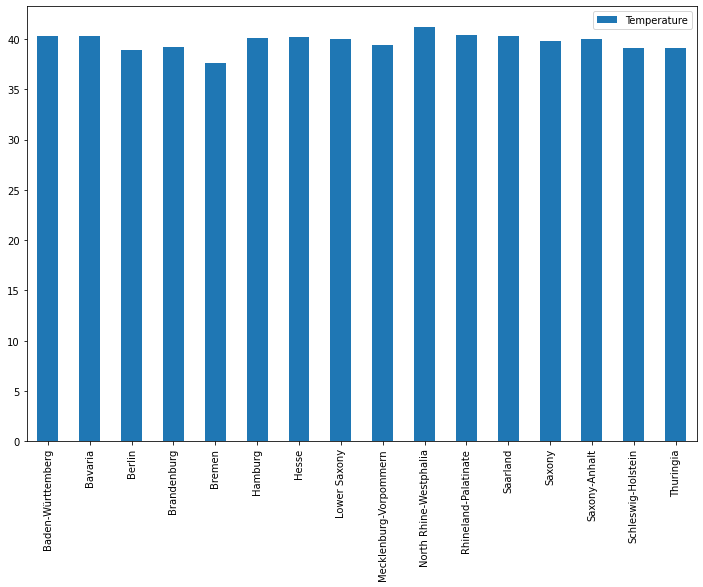

In [29]:
import matplotlib.pyplot as plt

ax = df.plot.bar(x="State", y="Temperature", figsize=(12,8));
ax.axes.get_xaxis().get_label().set_visible(False)